# Task 3 - Feature Engineering

This notebook transforms raw transaction data into customer-level features ready for modeling.

**Objectives:**
- Create aggregate features per customer (totals, averages, counts, std).
- Extract time-based features (hour, day, month, year).
- Encode categorical variables.
- Handle missing values.
- Normalize/standardize numerical features.
- Scaffold WoE/IV computation (requires target from Task 4).

## 1. Setup and Imports

In [1]:
import sys
from pathlib import Path

# Add src to path
PROJECT_ROOT = Path.cwd().parent
sys.path.insert(0, str(PROJECT_ROOT / "src"))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from data_processing import get_raw_data_path, load_raw_data
from feature_engineering import (
    add_time_features,
    aggregate_numeric_by_customer,
    aggregate_categorical_by_customer,
    build_customer_feature_table,
    get_feature_lists,
    build_preprocessing_pipeline,
    get_transformed_feature_names,
    compute_woe_iv,
)

# Plot settings
sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)

print("Imports successful.")

Imports successful.


## 2. Load Raw Data

In [2]:
data_path = get_raw_data_path()
print(f"Loading data from: {data_path}")

df_raw = load_raw_data(data_path)
print(f"Raw data shape: {df_raw.shape}")
df_raw.head()

Loading data from: /Users/macbookpro/Documents/Credit-Risk-Probability-Model/data/raw/data.csv
Raw data shape: (95662, 16)


,TransactionId,BatchId,AccountId,SubscriptionId,CustomerId,CurrencyCode,CountryCode,ProviderId,ProductId,ProductCategory,ChannelId,Amount,Value,TransactionStartTime,PricingStrategy,FraudResult
0,TransactionId_76871,BatchId_36123,AccountId_3957,SubscriptionId_887,CustomerId_4406,UGX,256,ProviderId_6,ProductId_10,airtime,ChannelId_3,1000.0,1000,2018-11-15T02:18:49Z,2,0
1,TransactionId_73770,BatchId_15642,AccountId_4841,SubscriptionId_3829,CustomerId_4406,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-20.0,20,2018-11-15T02:19:08Z,2,0
2,TransactionId_26203,BatchId_53941,AccountId_4229,SubscriptionId_222,CustomerId_4683,UGX,256,ProviderId_6,ProductId_1,airtime,ChannelId_3,500.0,500,2018-11-15T02:44:21Z,2,0
3,TransactionId_380,BatchId_102363,AccountId_648,SubscriptionId_2185,CustomerId_988,UGX,256,ProviderId_1,ProductId_21,utility_bill,ChannelId_3,20000.0,21800,2018-11-15T03:32:55Z,2,0
4,TransactionId_28195,BatchId_38780,AccountId_4841,SubscriptionId_3829,CustomerId_988,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-644.0,644,2018-11-15T03:34:21Z,2,0


## 3. Extract Time Features

Parse `TransactionStartTime` and add derived time columns.

In [3]:
df_txn = add_time_features(df_raw)

print("New time columns added:")
time_cols = ["txn_datetime", "txn_hour", "txn_day", "txn_month", "txn_year", "txn_dayofweek", "is_weekend"]
df_txn[time_cols].head()

New time columns added:


,txn_datetime,txn_hour,txn_day,txn_month,txn_year,txn_dayofweek,is_weekend
0,2018-11-15 02:18:49+00:00,2,15,11,2018,3,0
1,2018-11-15 02:19:08+00:00,2,15,11,2018,3,0
2,2018-11-15 02:44:21+00:00,2,15,11,2018,3,0
3,2018-11-15 03:32:55+00:00,3,15,11,2018,3,0
4,2018-11-15 03:34:21+00:00,3,15,11,2018,3,0


**Observation**: Each transaction now has parsed time features that we can aggregate per customer.

## 4. Create Aggregate Features per Customer

### 4.1 Numeric Aggregations

Compute per `CustomerId`:
- Transaction count
- Total/average/std/min/max of Amount
- Total/average of Value
- Average transaction hour, weekend ratio

In [4]:
df_numeric = aggregate_numeric_by_customer(df_txn)

print(f"Customer-level numeric features shape: {df_numeric.shape}")
print(f"Number of unique customers: {df_numeric['CustomerId'].nunique()}")
df_numeric.head(10)

Customer-level numeric features shape: (3742, 15)
Number of unique customers: 3742


,CustomerId,txn_count,total_amount,avg_amount,std_amount,min_amount,max_amount,total_value,avg_value,avg_txn_hour,std_txn_hour,weekend_txn_ratio,net_amount,n_credits,n_debits
0,CustomerId_1,1,-10000.0,-10000.000000,0.000000,-10000.0,-10000.0,10000,10000.000000,16.000000,0.000000,0.000000,-10000.0,1,0
1,CustomerId_10,1,-10000.0,-10000.000000,0.000000,-10000.0,-10000.0,10000,10000.000000,16.000000,0.000000,0.000000,-10000.0,1,0
2,CustomerId_1001,5,20000.0,4000.000000,6558.963333,-5000.0,10000.0,30400,6080.000000,7.800000,0.447214,0.000000,20000.0,2,3
3,CustomerId_1002,11,4225.0,384.090909,560.498966,-75.0,1500.0,4775,434.090909,13.454545,5.428879,0.181818,4225.0,6,5
4,CustomerId_1003,6,20000.0,3333.333333,6030.478146,-5000.0,10000.0,32000,5333.333333,14.333333,0.516398,0.000000,20000.0,2,4
5,CustomerId_1004,1,2000.0,2000.000000,0.000000,2000.0,2000.0,2000,2000.000000,18.000000,0.000000,1.000000,2000.0,0,1
6,CustomerId_1005,9,48800.0,5422.222222,5983.681513,-5000.0,10000.0,61200,6800.000000,10.111111,2.522124,0.000000,48800.0,3,6
7,CustomerId_1006,1,1000.0,1000.000000,0.000000,1000.0,1000.0,1000,1000.000000,7.000000,0.000000,0.000000,1000.0,0,1
8,CustomerId_1007,1,28000.0,28000.000000,0.000000,28000.0,28000.0,28000,28000.000000,6.000000,0.000000,1.000000,28000.0,0,1
9,CustomerId_1008,2,20000.0,10000.000000,0.000000,10000.0,10000.0,20000,10000.000000,13.000000,0.000000,1.000000,20000.0,0,2


**Observation**: We now have one row per customer with aggregated transaction behavior.

In [5]:
# Summary statistics of aggregated features
df_numeric.describe()

,txn_count,total_amount,avg_amount,std_amount,min_amount,max_amount,total_value,avg_value,avg_txn_hour,std_txn_hour,weekend_txn_ratio,net_amount,n_credits,n_debits
count,3742.000000,3.742000e+03,3.742000e+03,3.742000e+03,3.742000e+03,3.742000e+03,3.742000e+03,3.742000e+03,3742.000000,3742.000000,3742.000000,3.742000e+03,3742.000000,3742.000000
mean,25.564404,1.717377e+05,1.571562e+04,1.360517e+04,3.863506e+03,5.083873e+04,2.531025e+05,1.875612e+04,12.560712,2.375990,0.192653,1.717377e+05,10.205505,15.358899
std,96.929602,2.717305e+06,1.676991e+05,9.689344e+04,8.583664e+04,3.598691e+05,2.715877e+06,1.674529e+05,3.894273,2.325713,0.302505,2.717305e+06,73.171641,41.156871
min,1.000000,-1.049000e+08,-4.250000e+05,0.000000e+00,-1.000000e+06,-2.000000e+05,5.000000e+01,5.000000e+01,0.000000,0.000000,0.000000,-1.049000e+08,0.000000,0.000000
25%,2.000000,4.077438e+03,1.000000e+03,5.011411e+02,-5.000000e+03,2.000000e+03,6.500000e+03,1.160655e+03,10.000000,0.000000,0.000000,4.077438e+03,0.000000,2.000000
50%,7.000000,2.000000e+04,2.583846e+03,3.184898e+03,-1.000000e+03,1.000000e+04,3.200000e+04,3.950000e+03,12.500000,2.169229,0.000000,2.000000e+04,3.000000,4.000000
75%,20.000000,7.996775e+04,4.877614e+03,6.745369e+03,5.000000e+02,1.837500e+04,1.020600e+05,7.096039e+03,15.000000,4.403688,0.262979,7.996775e+04,7.000000,13.000000
max,4091.000000,8.345124e+07,8.601821e+06,3.309916e+06,2.000000e+06,9.880000e+06,1.049000e+08,8.601821e+06,23.000000,11.718931,1.000000,8.345124e+07,4091.000000,1105.000000


### 4.2 Categorical Aggregations

Compute proportions of transactions in top categories for `ProductCategory`, `ChannelId`, `ProviderId`.

In [6]:
df_categorical = aggregate_categorical_by_customer(df_txn, top_k=3)

print(f"Customer-level categorical features shape: {df_categorical.shape}")
df_categorical.head(10)

Customer-level categorical features shape: (3742, 10)


,CustomerId,productcategory_financial_services_ratio,productcategory_airtime_ratio,productcategory_utility_bill_ratio,channelid_channelid_3_ratio,channelid_channelid_2_ratio,channelid_channelid_5_ratio,providerid_providerid_4_ratio,providerid_providerid_6_ratio,providerid_providerid_5_ratio
0,CustomerId_1,0.000000,1.000000,0.0,0.000000,1.000000,0.0,1.000000,0.000000,0.000000
1,CustomerId_10,0.000000,1.000000,0.0,0.000000,1.000000,0.0,1.000000,0.000000,0.000000
2,CustomerId_1001,0.600000,0.400000,0.0,0.600000,0.400000,0.0,0.400000,0.400000,0.200000
3,CustomerId_1002,0.545455,0.454545,0.0,0.454545,0.545455,0.0,0.545455,0.000000,0.454545
4,CustomerId_1003,0.500000,0.500000,0.0,0.666667,0.333333,0.0,0.333333,0.500000,0.166667
5,CustomerId_1004,0.000000,1.000000,0.0,1.000000,0.000000,0.0,0.000000,0.000000,0.000000
6,CustomerId_1005,0.555556,0.444444,0.0,0.666667,0.333333,0.0,0.333333,0.333333,0.333333
7,CustomerId_1006,1.000000,0.000000,0.0,1.000000,0.000000,0.0,0.000000,0.000000,1.000000
8,CustomerId_1007,1.000000,0.000000,0.0,1.000000,0.000000,0.0,0.000000,0.000000,1.000000
9,CustomerId_1008,1.000000,0.000000,0.0,1.000000,0.000000,0.0,0.000000,0.000000,0.000000


**Observation**: Each customer now has proportion features showing their usage patterns across top categories.

## 5. Build Complete Feature Table

Combine numeric and categorical aggregations into one customer-level table.

In [7]:
df_features = build_customer_feature_table(df_raw, top_k=3)

print(f"Final feature table shape: {df_features.shape}")
print(f"\nFeature columns ({len(df_features.columns)}):")
print(df_features.columns.tolist())

Final feature table shape: (3742, 24)

Feature columns (24):
['CustomerId', 'txn_count', 'total_amount', 'avg_amount', 'std_amount', 'min_amount', 'max_amount', 'total_value', 'avg_value', 'avg_txn_hour', 'std_txn_hour', 'weekend_txn_ratio', 'net_amount', 'n_credits', 'n_debits', 'productcategory_financial_services_ratio', 'productcategory_airtime_ratio', 'productcategory_utility_bill_ratio', 'channelid_channelid_3_ratio', 'channelid_channelid_2_ratio', 'channelid_channelid_5_ratio', 'providerid_providerid_4_ratio', 'providerid_providerid_6_ratio', 'providerid_providerid_5_ratio']


In [8]:
df_features.head(10)

,CustomerId,txn_count,total_amount,avg_amount,std_amount,min_amount,max_amount,total_value,avg_value,avg_txn_hour,...,n_debits,productcategory_financial_services_ratio,productcategory_airtime_ratio,productcategory_utility_bill_ratio,channelid_channelid_3_ratio,channelid_channelid_2_ratio,channelid_channelid_5_ratio,providerid_providerid_4_ratio,providerid_providerid_6_ratio,providerid_providerid_5_ratio
0,CustomerId_1,1,-10000.0,-10000.000000,0.000000,-10000.0,-10000.0,10000,10000.000000,16.000000,...,0,0.000000,1.000000,0.0,0.000000,1.000000,0.0,1.000000,0.000000,0.000000
1,CustomerId_10,1,-10000.0,-10000.000000,0.000000,-10000.0,-10000.0,10000,10000.000000,16.000000,...,0,0.000000,1.000000,0.0,0.000000,1.000000,0.0,1.000000,0.000000,0.000000
2,CustomerId_1001,5,20000.0,4000.000000,6558.963333,-5000.0,10000.0,30400,6080.000000,7.800000,...,3,0.600000,0.400000,0.0,0.600000,0.400000,0.0,0.400000,0.400000,0.200000
3,CustomerId_1002,11,4225.0,384.090909,560.498966,-75.0,1500.0,4775,434.090909,13.454545,...,5,0.545455,0.454545,0.0,0.454545,0.545455,0.0,0.545455,0.000000,0.454545
4,CustomerId_1003,6,20000.0,3333.333333,6030.478146,-5000.0,10000.0,32000,5333.333333,14.333333,...,4,0.500000,0.500000,0.0,0.666667,0.333333,0.0,0.333333,0.500000,0.166667
5,CustomerId_1004,1,2000.0,2000.000000,0.000000,2000.0,2000.0,2000,2000.000000,18.000000,...,1,0.000000,1.000000,0.0,1.000000,0.000000,0.0,0.000000,0.000000,0.000000
6,CustomerId_1005,9,48800.0,5422.222222,5983.681513,-5000.0,10000.0,61200,6800.000000,10.111111,...,6,0.555556,0.444444,0.0,0.666667,0.333333,0.0,0.333333,0.333333,0.333333
7,CustomerId_1006,1,1000.0,1000.000000,0.000000,1000.0,1000.0,1000,1000.000000,7.000000,...,1,1.000000,0.000000,0.0,1.000000,0.000000,0.0,0.000000,0.000000,1.000000
8,CustomerId_1007,1,28000.0,28000.000000,0.000000,28000.0,28000.0,28000,28000.000000,6.000000,...,1,1.000000,0.000000,0.0,1.000000,0.000000,0.0,0.000000,0.000000,1.000000
9,CustomerId_1008,2,20000.0,10000.000000,0.000000,10000.0,10000.0,20000,10000.000000,13.000000,...,2,1.000000,0.000000,0.0,1.000000,0.000000,0.0,0.000000,0.000000,0.000000


## 6. Handle Missing Values

Check for any missing values in the feature table.

In [9]:
missing_counts = df_features.isnull().sum()
missing_pct = (missing_counts / len(df_features)) * 100

missing_df = pd.DataFrame({
    "column": missing_counts.index,
    "n_missing": missing_counts.values,
    "pct_missing": missing_pct.values
}).sort_values("pct_missing", ascending=False)

missing_df[missing_df["n_missing"] > 0]

,column,n_missing,pct_missing


**Observation**: Our pipeline includes `SimpleImputer` to handle any missing values that may arise. If none exist, the imputer passes data through unchanged.

## 7. Normalize/Standardize Numerical Features

Build the sklearn preprocessing pipeline with:
- `SimpleImputer` for missing values
- `StandardScaler` for numeric features
- `OneHotEncoder` for categorical features (if any)

In [10]:
# Identify feature types
numeric_features, categorical_features = get_feature_lists(df_features)

print(f"Numeric features ({len(numeric_features)}): {numeric_features[:5]}...")
print(f"Categorical features ({len(categorical_features)}): {categorical_features}")

Numeric features (23): ['txn_count', 'total_amount', 'avg_amount', 'std_amount', 'min_amount']...
Categorical features (0): []


In [11]:
# Build preprocessing pipeline
pipeline = build_preprocessing_pipeline(numeric_features, categorical_features)

print("Pipeline structure:")
print(pipeline)

Pipeline structure:
Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['txn_count', 'total_amount',
                                                   'avg_amount', 'std_amount',
                                                   'min_amount', 'max_amount',
                                                   'total_value', 'avg_value',
                                                   'avg_txn_hour',
                                                   'std_txn_hour',
                                                   'weekend_txn_ratio',
                      

In [12]:
# Fit and transform
X = df_features[numeric_features + categorical_features]
X_transformed = pipeline.fit_transform(X)

print(f"Transformed shape: {X_transformed.shape}")
print(f"\nFirst 5 rows (first 5 features):")
print(X_transformed[:5, :5])

Transformed shape: (3742, 23)

First 5 rows (first 5 features):
[[-0.25345907 -0.06689056 -0.15336429 -0.14043247 -0.16153194]
 [-0.25345907 -0.06689056 -0.15336429 -0.14043247 -0.16153194]
 [-0.21218649 -0.05584873 -0.06987027 -0.07273088 -0.10327397]
 [-0.15027763 -0.06165489 -0.09143504 -0.134647   -0.04588987]
 [-0.20186835 -0.05584873 -0.07384618 -0.0781859  -0.10327397]]


In [13]:
# Get feature names after transformation
feature_names = get_transformed_feature_names(pipeline, numeric_features, categorical_features)

# Create DataFrame with transformed data
df_transformed = pd.DataFrame(X_transformed, columns=feature_names)
df_transformed.insert(0, "CustomerId", df_features["CustomerId"].values)

print(f"Transformed feature table shape: {df_transformed.shape}")
df_transformed.head()

Transformed feature table shape: (3742, 24)


,CustomerId,txn_count,total_amount,avg_amount,std_amount,min_amount,max_amount,total_value,avg_value,avg_txn_hour,...,n_debits,productcategory_financial_services_ratio,productcategory_airtime_ratio,productcategory_utility_bill_ratio,channelid_channelid_3_ratio,channelid_channelid_2_ratio,channelid_channelid_5_ratio,providerid_providerid_4_ratio,providerid_providerid_6_ratio,providerid_providerid_5_ratio
0,CustomerId_1,-0.253459,-0.066891,-0.153364,-0.140432,-0.161532,-0.169081,-0.089524,-0.052297,0.883284,...,-0.373229,-1.904511,2.073016,-0.230127,-2.804440,3.137802,-0.147303,3.038494,-1.035605,-0.789009
1,CustomerId_10,-0.253459,-0.066891,-0.153364,-0.140432,-0.161532,-0.169081,-0.089524,-0.052297,0.883284,...,-0.373229,-1.904511,2.073016,-0.230127,-2.804440,3.137802,-0.147303,3.038494,-1.035605,-0.789009
2,CustomerId_1001,-0.212186,-0.055849,-0.069870,-0.072731,-0.103274,-0.113497,-0.082011,-0.075710,-1.222654,...,-0.300328,0.268985,-0.039359,-0.230127,-0.342663,0.480118,-0.147303,0.422898,0.692256,-0.131393
3,CustomerId_1002,-0.150278,-0.061655,-0.091435,-0.134647,-0.045890,-0.137120,-0.091448,-0.109431,0.229556,...,-0.251727,0.071395,0.152675,-0.230127,-0.939458,1.124405,-0.147303,1.056982,-1.035605,0.705571
4,CustomerId_1003,-0.201868,-0.055849,-0.073846,-0.078186,-0.103274,-0.113497,-0.081422,-0.080169,0.455248,...,-0.276027,-0.093264,0.312703,-0.230127,-0.069133,0.184820,-0.147303,0.132276,1.124221,-0.240996


**Observation**: All numeric features are now standardized (mean ~0, std ~1). This is ready for modeling.

In [14]:
# Verify standardization
print("Post-transformation statistics (should be ~0 mean, ~1 std):")
df_transformed[numeric_features[:5]].describe().loc[["mean", "std"]]

Post-transformation statistics (should be ~0 mean, ~1 std):


,txn_count,total_amount,avg_amount,std_amount,min_amount
mean,-7.595326e-18,-9.494157e-18,0.000000,1.139299e-17,0.000000
std,1.000134e+00,1.000134e+00,1.000134,1.000134e+00,1.000134


## 8. Visualize Engineered Features

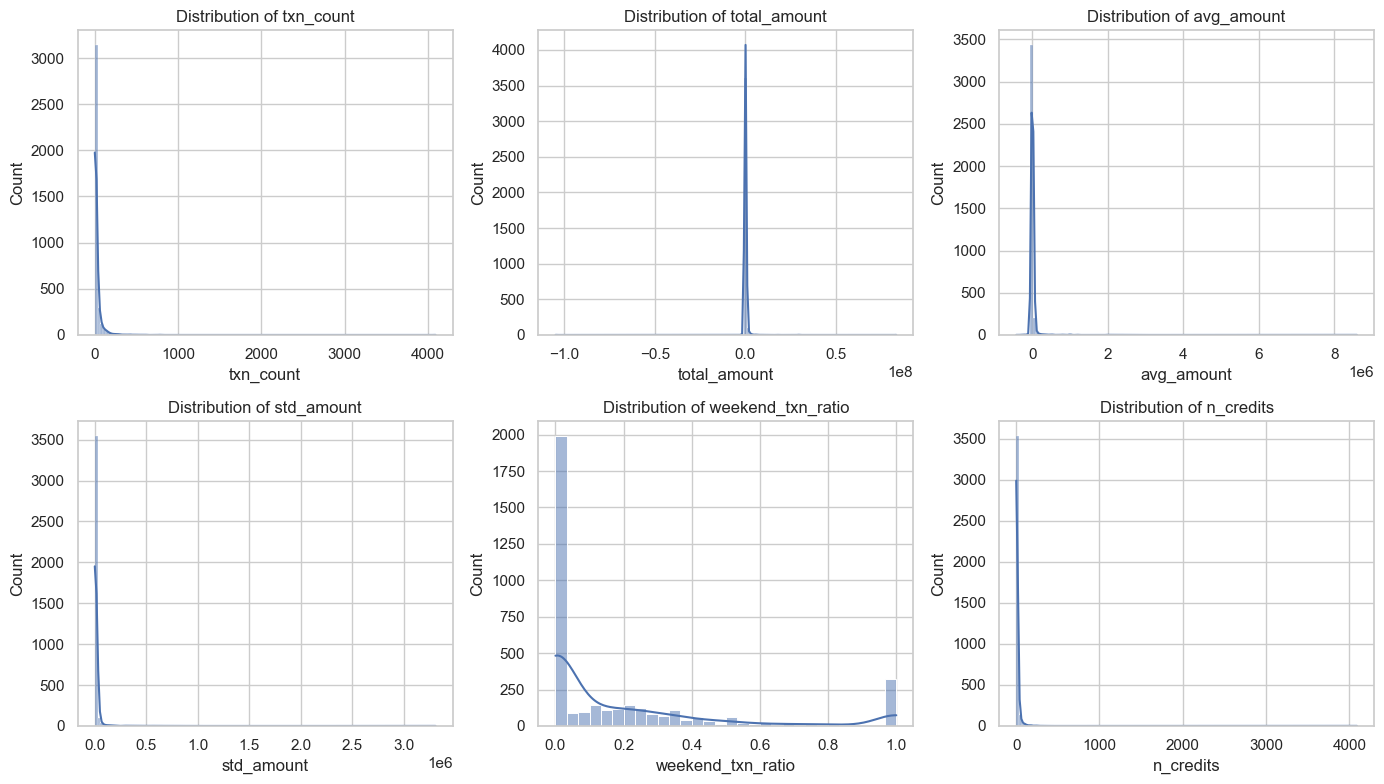

In [15]:
# Distribution of key features (before scaling)
fig, axes = plt.subplots(2, 3, figsize=(14, 8))

features_to_plot = ["txn_count", "total_amount", "avg_amount", "std_amount", "weekend_txn_ratio", "n_credits"]

for ax, feat in zip(axes.flatten(), features_to_plot):
    if feat in df_features.columns:
        sns.histplot(df_features[feat], ax=ax, kde=True)
        ax.set_title(f"Distribution of {feat}")
        ax.set_xlabel(feat)

plt.tight_layout()
plt.show()

**Observation**: 
- `txn_count` is heavily right-skewed (most customers have few transactions, some have many).
- `total_amount` and `avg_amount` also show skewness, consistent with EDA findings.
- `weekend_txn_ratio` shows varied customer behavior patterns.

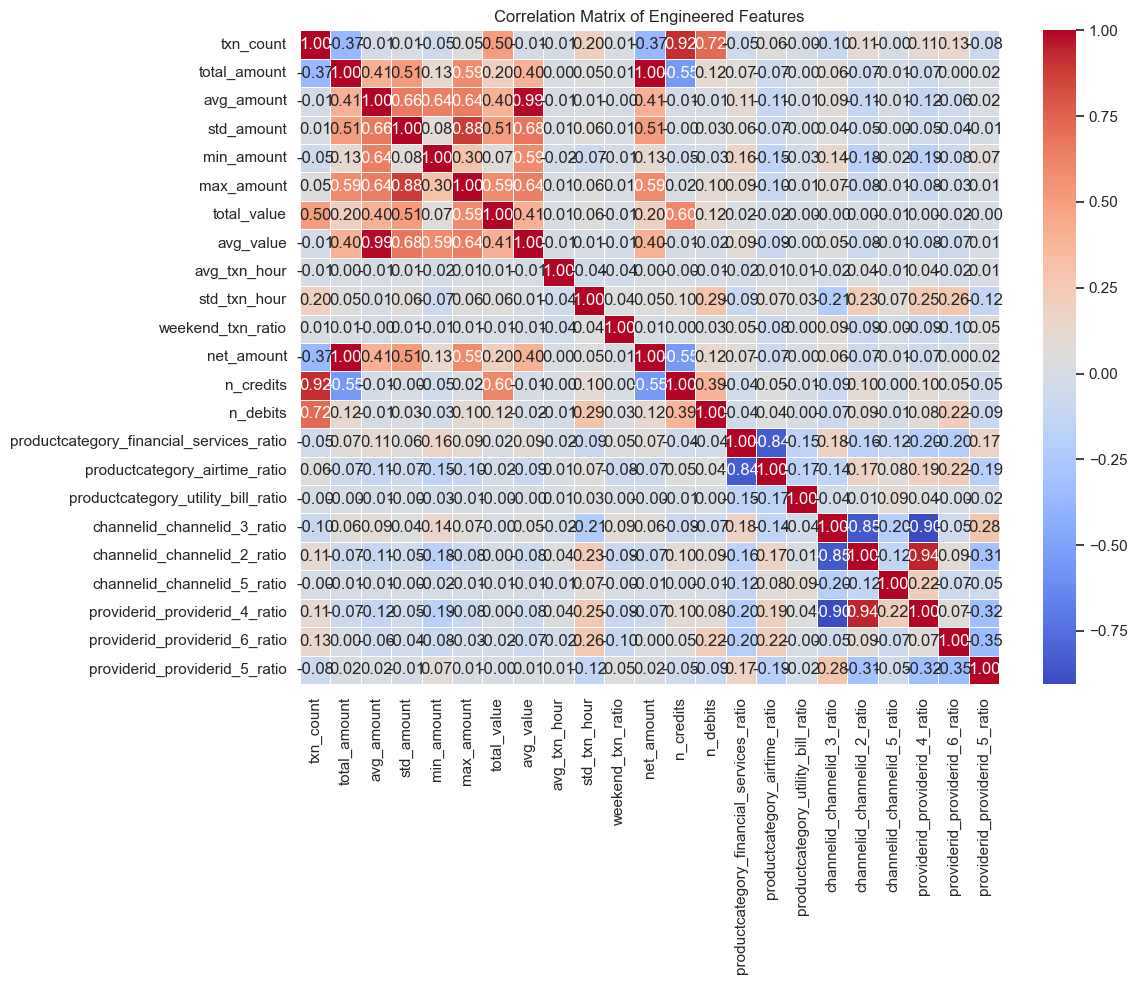

In [16]:
# Correlation heatmap of engineered features
plt.figure(figsize=(12, 10))
corr = df_features[numeric_features].corr()
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix of Engineered Features")
plt.tight_layout()
plt.show()

**Observation**: Some features are highly correlated (e.g., `total_amount` and `total_value`). We may consider dropping redundant features or using dimensionality reduction later.

## 9. WoE and IV (Placeholder)

Weight of Evidence (WoE) and Information Value (IV) require a **binary target variable**.

We will compute these in **Task 4** after defining the `is_high_risk` proxy target via RFM clustering.

For now, here's an example of how the `compute_woe_iv` function works with a dummy target:

In [17]:
# Create a dummy target for demonstration
np.random.seed(42)
df_features_demo = df_features.copy()
df_features_demo["dummy_target"] = np.random.choice([0, 1], size=len(df_features_demo), p=[0.9, 0.1])

# Compute WoE/IV for txn_count
woe_result = compute_woe_iv(df_features_demo, "txn_count", "dummy_target", bins=5)

print("WoE/IV Example (dummy target):")
woe_result

WoE/IV Example (dummy target):


/Users/macbookpro/Documents/Credit-Risk-Probability-Model/src/feature_engineering.py:348: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby("bin")[target_col].agg(["sum", "count"])


,bin,bad,total,good,dist_bad,dist_good,woe,iv,total_iv
0,"(0.999, 2.0]",93,962,869,0.257618,0.257025,-0.002305,0.000001,0.015407
1,"(2.0, 5.0]",73,666,593,0.202216,0.175392,-0.142314,0.003817,0.015407
2,"(5.0, 10.0]",54,659,605,0.149584,0.178941,0.179196,0.005261,0.015407
3,"(10.0, 26.0]",77,711,634,0.213296,0.187518,-0.128805,0.003320,0.015407
4,"(26.0, 4091.0]",64,744,680,0.177285,0.201124,0.126161,0.003007,0.015407


**Observation**: 
- WoE shows the predictive relationship between feature bins and the target.
- IV (total) indicates feature importance: IV > 0.5 is strong, 0.1-0.3 is medium, < 0.02 is weak.
- We'll compute real WoE/IV in Task 4 with the actual proxy target.

## 10. Save Processed Features

Save the customer-level feature table for use in Task 4 (proxy target) and Task 5 (modeling).

In [18]:
# Save to processed folder
output_path = PROJECT_ROOT / "data" / "processed" / "customer_features.csv"
output_path.parent.mkdir(parents=True, exist_ok=True)

df_features.to_csv(output_path, index=False)
print(f"Saved customer features to: {output_path}")
print(f"Shape: {df_features.shape}")

Saved customer features to: /Users/macbookpro/Documents/Credit-Risk-Probability-Model/data/processed/customer_features.csv
Shape: (3742, 24)


## 11. Summary

### Features Created

**Numeric Aggregations per Customer:**
- `txn_count`: Number of transactions
- `total_amount`, `avg_amount`, `std_amount`, `min_amount`, `max_amount`: Amount statistics
- `total_value`, `avg_value`: Value statistics
- `avg_txn_hour`, `std_txn_hour`: Transaction timing patterns
- `weekend_txn_ratio`: Proportion of weekend transactions
- `net_amount`: Net transaction flow
- `n_credits`, `n_debits`: Count of credit/debit transactions

**Categorical Proportions:**
- `productcategory_*_ratio`: Share of transactions in top product categories
- `channelid_*_ratio`: Share of transactions in top channels
- `providerid_*_ratio`: Share of transactions with top providers

### Pipeline Components

- **Imputation**: `SimpleImputer(strategy='median')` for numeric, `SimpleImputer(strategy='constant')` for categorical
- **Scaling**: `StandardScaler` for numeric features
- **Encoding**: `OneHotEncoder` for any remaining categorical features

### Next Steps (Task 4)

1. Compute RFM (Recency, Frequency, Monetary) metrics.
2. Cluster customers using K-Means.
3. Define `is_high_risk` proxy target based on cluster analysis.
4. Compute real WoE/IV with the actual target.